### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

In [1]:
# сделайте разделение изначального набора данных в этой ячейке
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import os
from autofeat import AutoFeatRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold, cross_validate
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.model_selection._validation")




ASSETS_DIR = "assets"
FS_ASSETS_DI = 'assets_fs'
HYP_ASSETS_DIR = 'assets_hyperopt'

os.makedirs(ASSETS_DIR, exist_ok=True)
os.makedirs(FS_ASSETS_DI, exist_ok=True)
os.makedirs(HYP_ASSETS_DIR, exist_ok=True)

seed = 42

df = pd.read_csv('initial_data.csv')
df['building_type_int'] = df['building_type_int'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(df.drop('price',axis=1), df['price'], test_size=0.2, random_state=seed)


In [2]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")


#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [3]:
# 2.1 Загрузка данных

In [4]:
df = df.reset_index()

In [5]:
df.head()

,index,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,0,22315,4,7.8,17.6,1,False,False,34.299999,5350000.0,2013,2,55.504986,37.534801,2.70,660,17,True
1,1,24504,12,16.0,32.0,2,False,False,56.900002,9690000.0,2020,2,55.572639,37.485806,2.85,227,12,True
2,2,23303,3,12.4,33.0,2,False,False,53.799999,9200000.0,2016,2,55.573334,37.490517,3.00,264,12,True
3,3,22328,8,15.0,42.0,3,False,False,75.599998,12500000.0,2013,2,55.572762,37.483112,2.80,455,17,True
4,4,22288,1,11.0,25.0,1,False,False,41.000000,6300000.0,2013,1,55.567425,37.475487,2.80,245,12,True


In [6]:
# 2.2. Общий обзор датасета

In [7]:
df.isna().sum()

index                0
building_id          0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
studio               0
total_area           0
price                0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104095 entries, 0 to 104094
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              104095 non-null  int64  
 1   building_id        104095 non-null  int64  
 2   floor              104095 non-null  int64  
 3   kitchen_area       104095 non-null  float64
 4   living_area        104095 non-null  float64
 5   rooms              104095 non-null  int64  
 6   is_apartment       104095 non-null  bool   
 7   studio             104095 non-null  bool   
 8   total_area         104095 non-null  float64
 9   price              104095 non-null  float64
 10  build_year         104095 non-null  int64  
 11  building_type_int  104095 non-null  object 
 12  latitude           104095 non-null  float64
 13  longitude          104095 non-null  float64
 14  ceiling_height     104095 non-null  float64
 15  flats_count        104095 non-null  int64  
 16  fl

In [9]:
df.describe()

,index,building_id,floor,kitchen_area,living_area,rooms,total_area,price,build_year,latitude,longitude,ceiling_height,flats_count,floors_total
count,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,1.040950e+05,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000
mean,52047.000000,13504.084596,7.032855,8.378249,27.595582,1.948499,52.074677,1.192439e+07,1985.117710,55.726589,37.600759,2.692437,243.147951,13.327509
std,30049.782473,6520.896811,4.914407,3.536494,14.506247,0.814888,16.527051,4.580951e+06,19.751087,0.104199,0.149270,0.133727,170.087483,5.311246
min,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.100000e+01,1902.000000,55.427238,37.190201,2.450000,1.000000,1.000000
25%,26023.500000,8390.000000,3.000000,6.100000,19.000000,1.000000,38.500000,8.600000e+06,1969.000000,55.646149,37.493713,2.640000,117.000000,9.000000
50%,52047.000000,13269.000000,6.000000,8.500000,28.500000,2.000000,49.700001,1.099000e+07,1981.000000,55.715603,37.589050,2.640000,203.000000,12.000000
75%,78070.500000,19046.000000,10.000000,10.000000,36.000000,3.000000,61.400002,1.420000e+07,2003.000000,55.813389,37.718697,2.740000,320.000000,17.000000
max,104094.000000,24620.000000,29.000000,102.000000,74.000000,7.000000,118.500000,2.840000e+07,2023.000000,56.011032,37.946411,3.000000,4455.000000,29.000000


In [10]:
df.nunique()

index                104095
building_id           20885
floor                    28
kitchen_area            734
living_area            1408
rooms                     6
is_apartment              2
studio                    1
total_area             1838
price                  4097
build_year              115
building_type_int         7
latitude              14471
longitude             14112
ceiling_height           35
flats_count             693
floors_total             29
has_elevator              2
dtype: int64

In [11]:
# 2.3 Анализ признаков для модели

2025-04-02 19:38:16,401 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-02 19:38:16,410 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


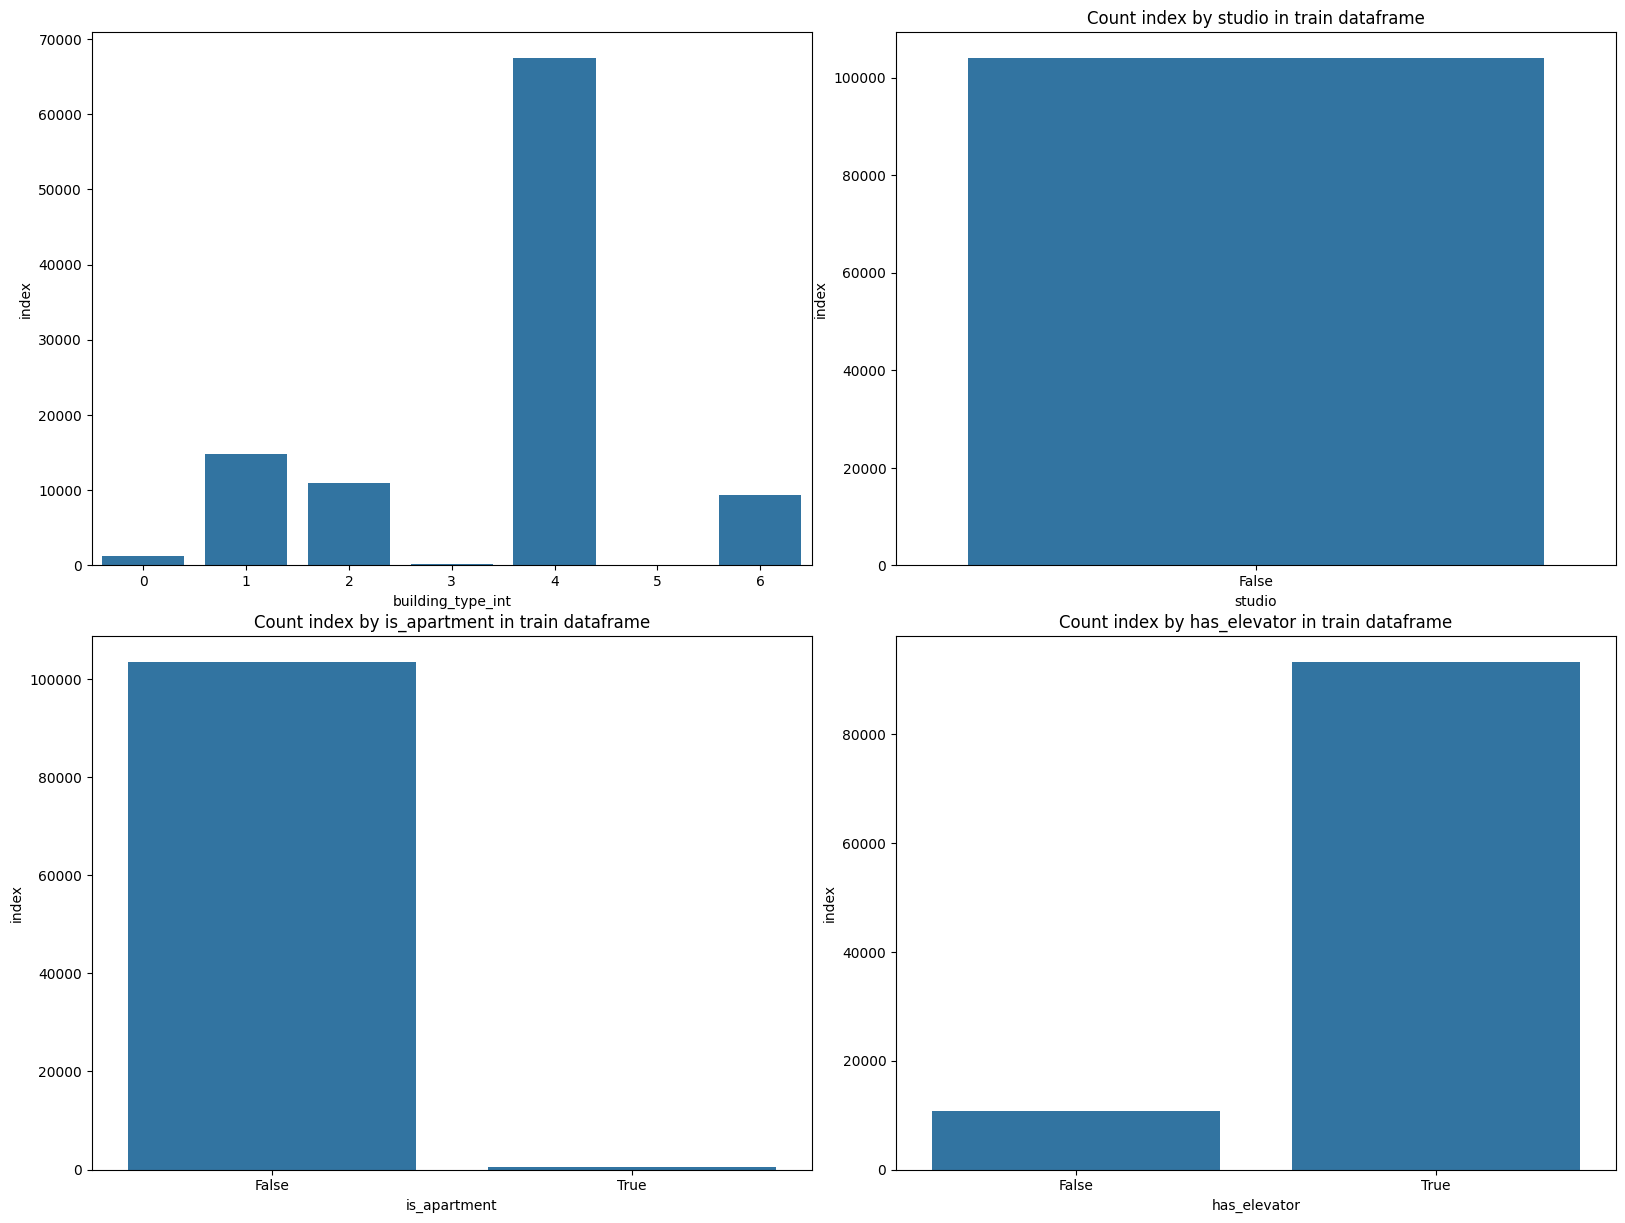

In [12]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3)


x = "building_type_int"
y = "index"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])


x = "studio"
y = "index"
# ваш код тут #
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "is_apartment"
y = "index"
# ваш код тут #
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "has_elevator"
y = "index"
# ваш код тут #
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

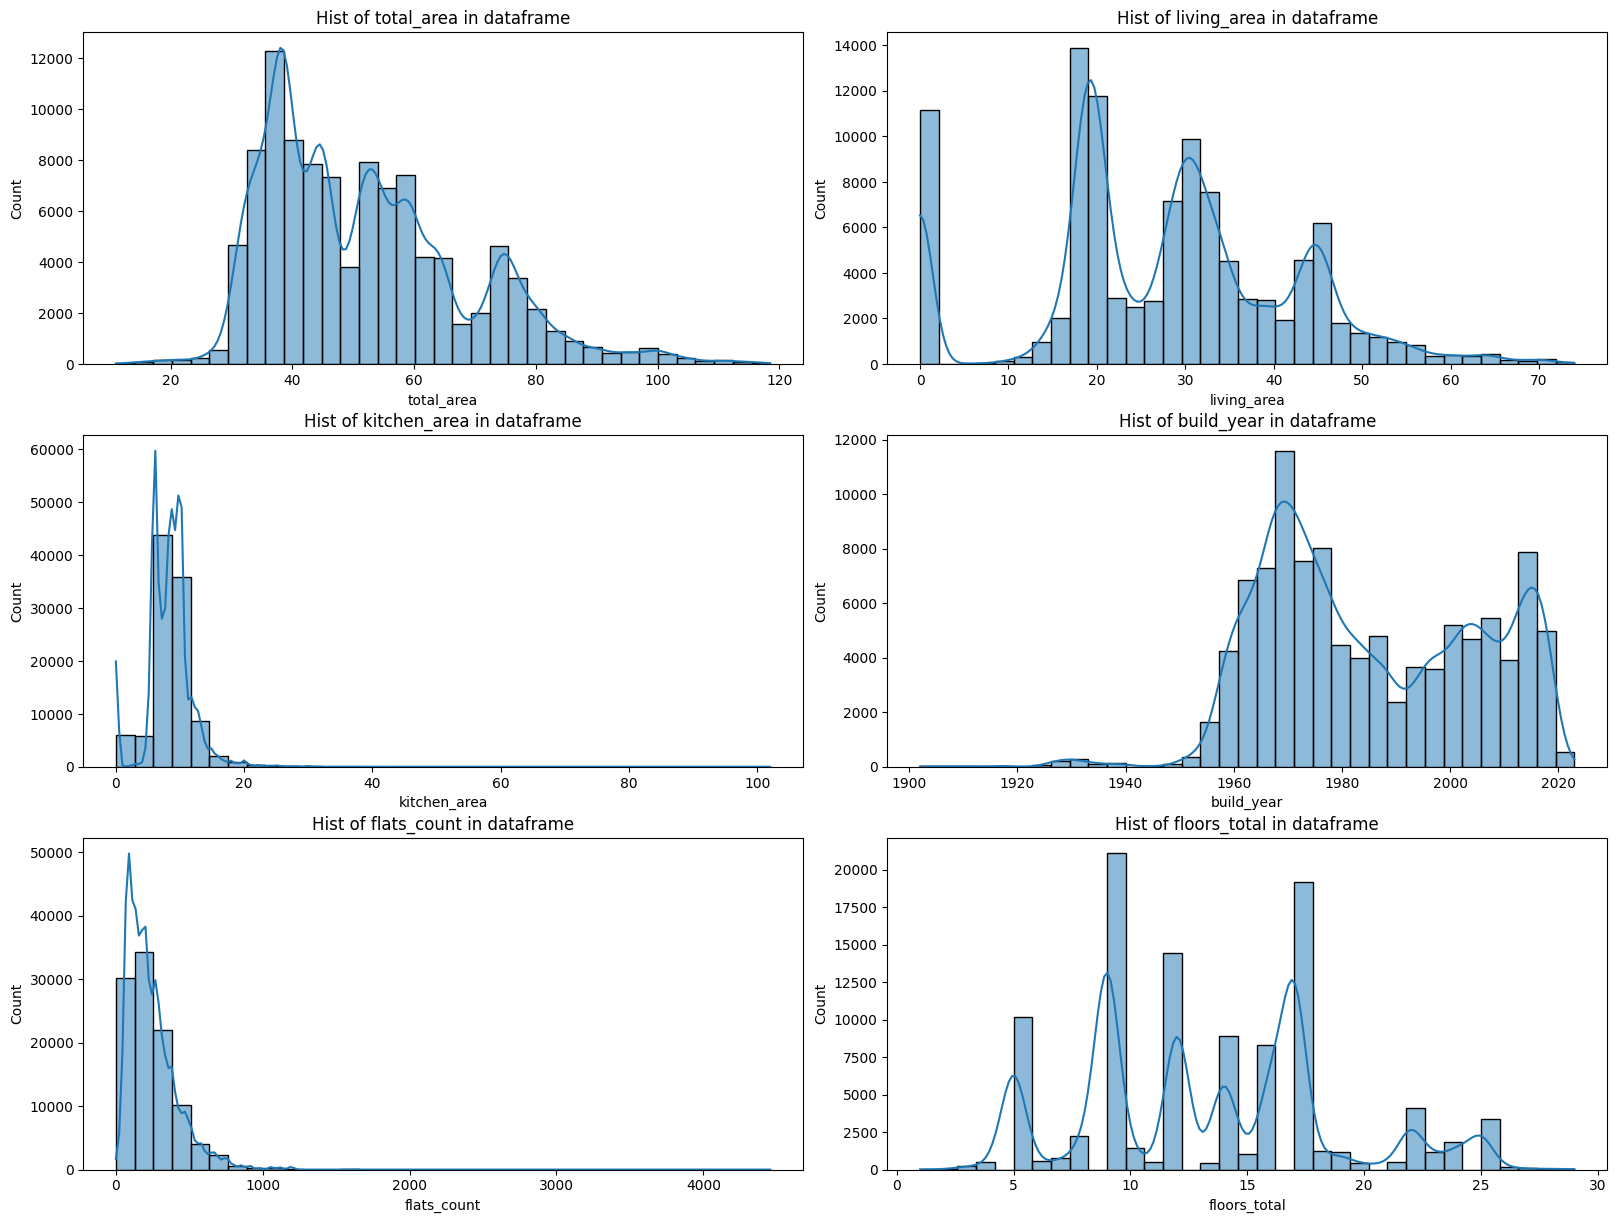

In [13]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3)

x='total_area'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[0, 0])
axs[0, 0].set_title(f'Hist of {x} in dataframe')

x='living_area'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[0, 1])
axs[0, 1].set_title(f'Hist of {x} in dataframe')

x='kitchen_area'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[1, 0])
axs[1, 0].set_title(f'Hist of {x} in dataframe')

x='build_year'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[1, 1])
axs[1, 1].set_title(f'Hist of {x} in dataframe')

x='flats_count'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[2, 0])
axs[2, 0].set_title(f'Hist of {x} in dataframe')

x='floors_total'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[2, 1])
axs[2, 1].set_title(f'Hist of {x} in dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'num_features_dist'))

In [14]:
# 2.4 Анализ целевой переменной

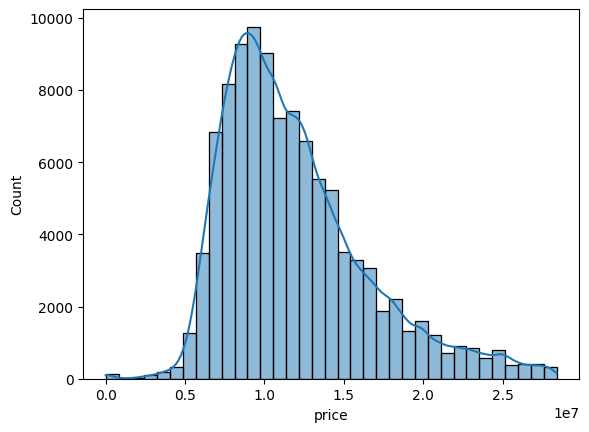

In [15]:
x='price'
sns.histplot(data=df, x=x, kde=True, bins=35)
plt.savefig(os.path.join(ASSETS_DIR, 'dist_of_target'))

In [16]:
df['price'].describe()

count    1.040950e+05
mean     1.192439e+07
std      4.580951e+06
min      1.100000e+01
25%      8.600000e+06
50%      1.099000e+07
75%      1.420000e+07
max      2.840000e+07
Name: price, dtype: float64

In [17]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

In [18]:
num_cols = ['price','total_area','living_area','kitchen_area','build_year','flats_count','floors_total'
           ,'rooms','ceiling_height','latitude','longitude']

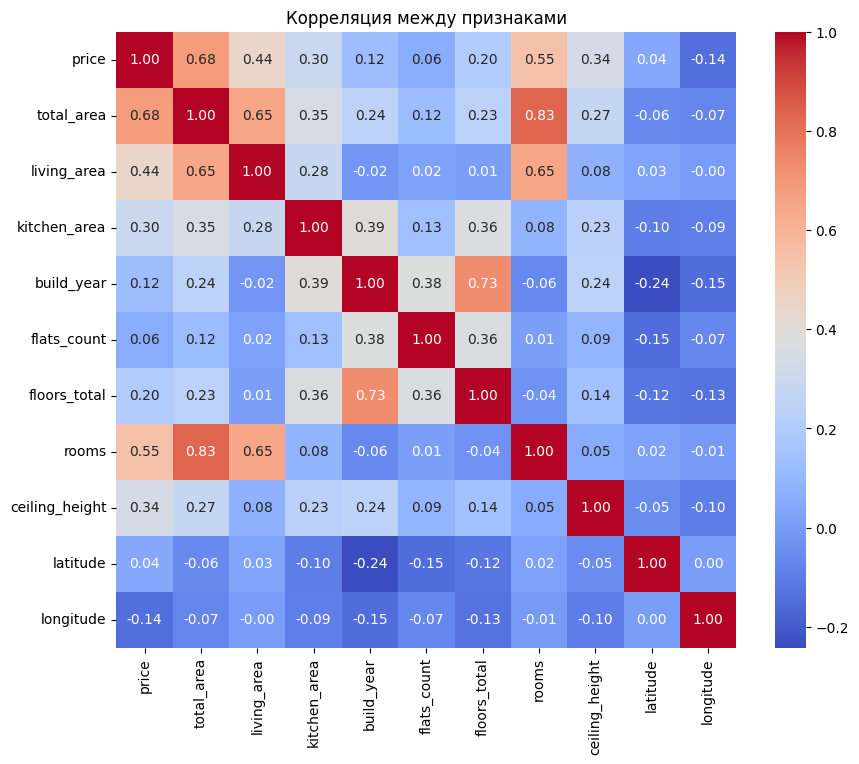

In [19]:
correlations_with_price = df[num_cols].corr()

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_with_price, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между признаками')

plt.savefig(os.path.join(ASSETS_DIR, 'corr_with_target'))

In [20]:
cat_and_bin_cols = ['is_apartment','has_elevator','building_type_int']

2025-04-02 19:38:22,707 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-02 19:38:22,758 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


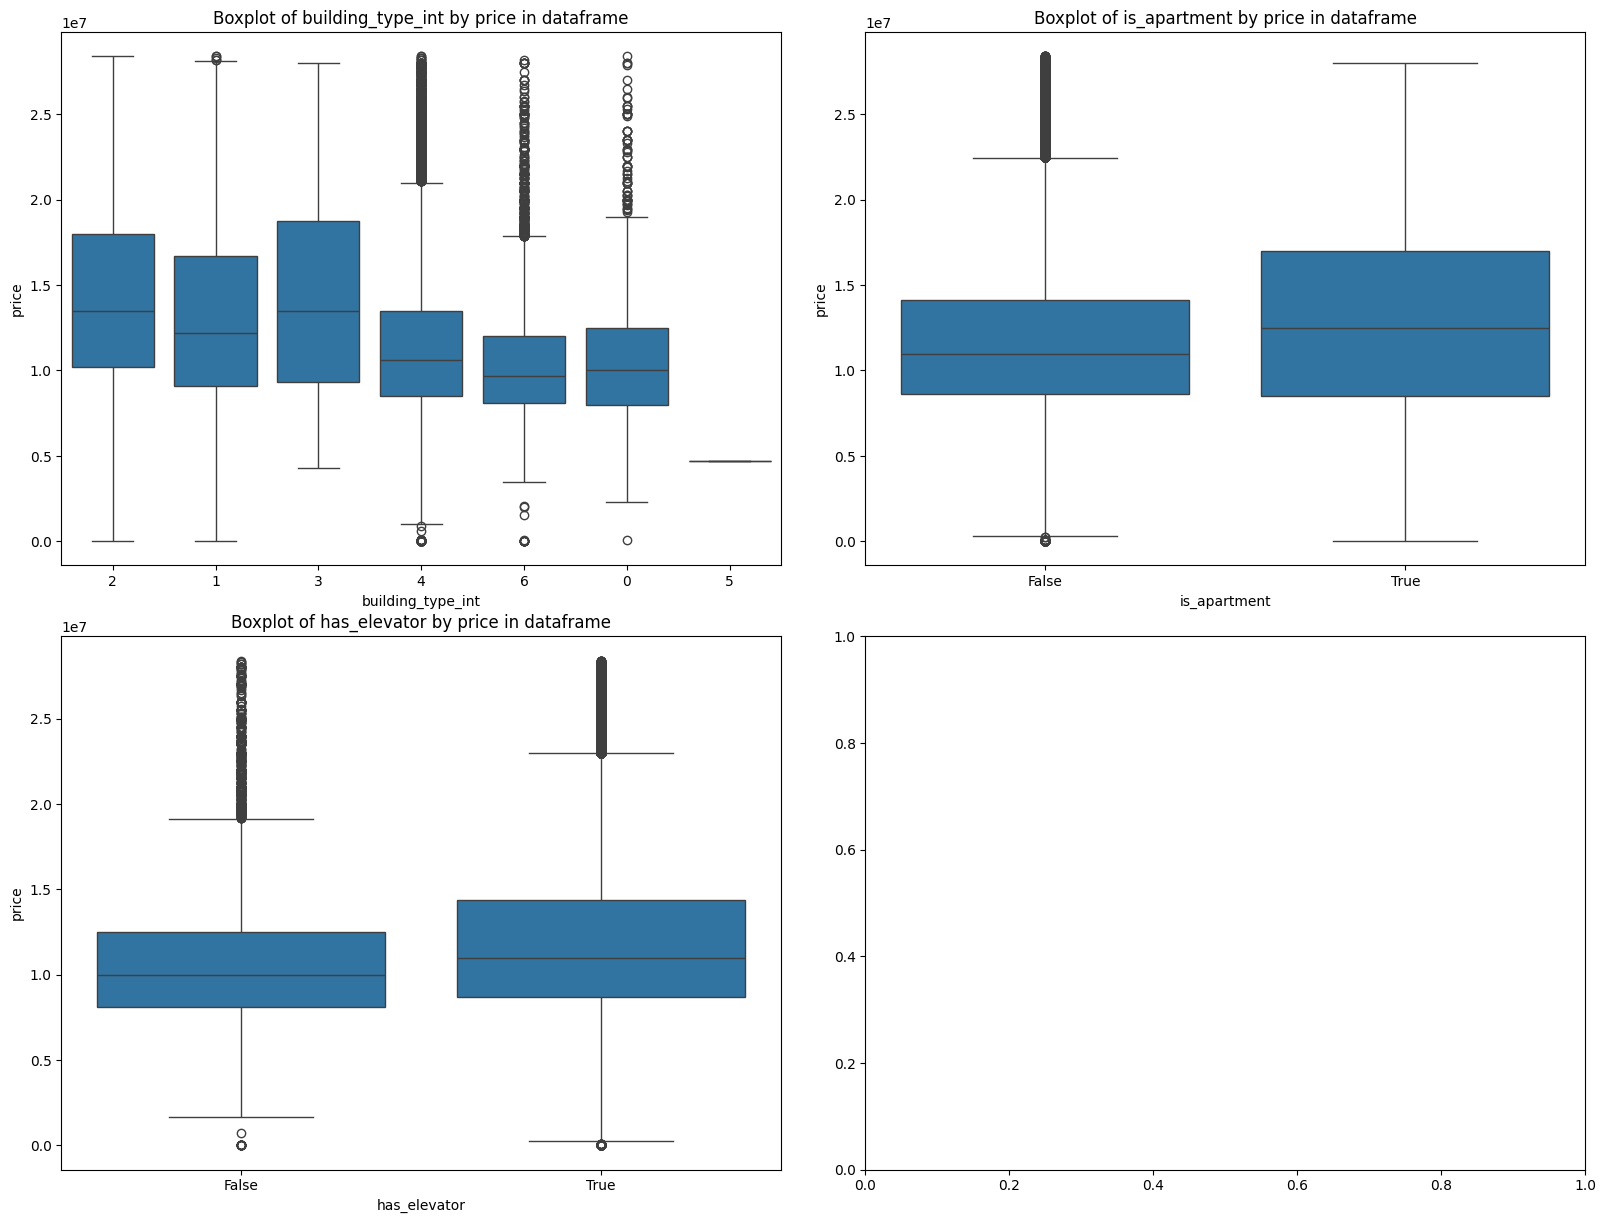

In [21]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3)
y = "price"


x = 'building_type_int'
sns.boxplot(data=df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Boxplot of {x} by {y} in dataframe')

x = 'is_apartment'
sns.boxplot(data=df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Boxplot of {x} by {y} in dataframe')

x = 'has_elevator'
sns.boxplot(data=df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Boxplot of {x} by {y} in dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'price_boxplot_cat_bin_feats'))

In [22]:
# 2.5 Выводы после EDA

Данные на момент их использования моделью уже были отчищены от выбросов и не имеют пустых значений

Есть лишний признак только с одним значением:
studio

По ряду категориальных и бинарных признаков виден дисбаланс например:
building_type_int 
is_apartment 
has_elevator 

Все числовые признаки несмотря на удаление выбросов имеют тяжелые хвосты

Таргет наиболее "приближен" к нормальному распределению но тоже с тяжелыми хвостами и скосом в лево

Корреляционный анализ показывает что наиболее сильные признаки это признаки которые непосредственно касаются размера квартиры kitchen_area living_area ceiling_height total_area

Также разбивка таргета по категориальным и бинырным фичам boxplot показывает что между различными категориями есть разница в цене првада building_type_int = 5 имеет слишком мало значений чтобы его можно было анализировать

In [23]:
# 2.6 логирование артефактов в MLflow

In [24]:
markdown_content = """# Ключевые выводы EDA
Данные на момент их использования моделью уже были отчищены от выбросов и не имеют пустых значений

Есть лишний признак только с одним значением:
studio

По ряду категориальных и бинарных признаков виден дисбаланс например:
building_type_int 
is_apartment 
has_elevator 

Все числовые признаки несмотря на удаление выбросов имеют тяжелые хвосты

Таргет наиболее "приближен" к нормальному распределению но тоже с тяжелыми хвостами и скосом в лево

Корреляционный анализ показывает что наиболее сильные признаки это признаки которые непосредственно касаются размера квартиры kitchen_area living_area ceiling_height total_area

Также разбивка таргета по категориальным и бинырным фичам boxplot показывает что между различными категориями есть разница в цене првада building_type_int = 5 имеет слишком мало значений чтобы его можно было анализировать
"""
markdown_file = f"{ASSETS_DIR}/eda_summary.md"
with open(markdown_file, "w") as f:
    f.write(markdown_content)


In [26]:
EXPERIMENT_NAME = "sprint2_appartment_price"
RUN_NAME = "save_stage_2_eda"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    notebook_path = "project_sprint_2.ipynb"
    mlflow.log_artifact(notebook_path)

    mlflow.log_artifacts(ASSETS_DIR) 

2025-02-25 13:41:24,529 INFO: Found credentials in environment variables.


#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [25]:
# 3.1 ручная генерация признаков

In [3]:
X_train['ratio_living_area'] = X_train['living_area'] / X_train['total_area']
X_test['ratio_living_area'] = X_test['living_area'] / X_test['total_area']

X_train['ratio_kitchen_area'] = X_train['kitchen_area'] / X_train['total_area']
X_test['ratio_kitchen_area'] = X_test['kitchen_area'] / X_test['total_area']

X_train['mean_flats_area'] = X_train['total_area'] / X_train['flats_count']
X_test['mean_flats_area'] = X_test['total_area'] / X_test['flats_count']

In [4]:
cat_cols = ['building_type_int']
bin_cols = ['is_apartment','has_elevator']
num_features = ['total_area','living_area','kitchen_area','build_year','flats_count','floors_total'
           ,'rooms','ceiling_height','ratio_living_area','ratio_kitchen_area','mean_flats_area']
geo_feats=['latitude','longitude']

features = cat_cols + num_features + bin_cols + geo_feats

transformations = ("1/", "exp", "log","sin", "cos", "exp-")

In [5]:
# 3.2 оборачивание всех преобразований в объекты sklearn

In [6]:
afc = AutoFeatRegressor(transformations=transformations, feateng_steps=1, n_jobs=-1)


In [30]:
# 3.3 автоматическая генерация признаков

In [30]:

preprocessor = ColumnTransformer(
        [
        ('binary', OneHotEncoder(drop='if_binary'), bin_cols),
        ('cat', CatBoostEncoder(return_df=False), cat_cols),
        ('num', StandardScaler(), num_features+geo_feats),
        ('poly', PolynomialFeatures(degree=2, include_bias=False), num_features),
        ('kbin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), num_features)
        ],
        remainder='drop',
        verbose_feature_names_out=False
        )

model = CatBoostRegressor(loss_function='RMSE')

pipeline = Pipeline(
[
    ('preprocessor', preprocessor),
    ('autofeat', afc),
    ('model', model)
]
)

cv_res = cross_validate(
    pipeline,
    X_train[features],
    y_train,
    cv=4,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    )

for key, value in cv_res.items():
    cv_res[key] = round(value.mean(), 3)  



/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.373e-02, with an active set of 24 regressors, and the smallest c

Learning rate set to 0.078683
0:	learn: 4382274.5345262	total: 179ms	remaining: 2m 58s
1:	learn: 4204254.3953761	total: 279ms	remaining: 2m 19s
2:	learn: 4043248.2946173	total: 360ms	remaining: 1m 59s
3:	learn: 3907300.5271254	total: 426ms	remaining: 1m 45s
4:	learn: 3782791.6071741	total: 515ms	remaining: 1m 42s
5:	learn: 3664871.7318283	total: 610ms	remaining: 1m 41s
6:	learn: 3558790.0228655	total: 705ms	remaining: 1m 39s
7:	learn: 3466960.3396362	total: 792ms	remaining: 1m 38s
8:	learn: 3383059.1013441	total: 894ms	remaining: 1m 38s
9:	learn: 3307141.7795884	total: 981ms	remaining: 1m 37s
10:	learn: 3240833.3686806	total: 1.07s	remaining: 1m 36s
11:	learn: 3180930.5676754	total: 1.15s	remaining: 1m 34s
12:	learn: 3125993.7091099	total: 1.23s	remaining: 1m 33s
13:	learn: 3078633.1545099	total: 1.32s	remaining: 1m 33s
14:	learn: 3035257.4321710	total: 1.41s	remaining: 1m 32s
15:	learn: 2994594.5215690	total: 1.51s	remaining: 1m 32s
16:	learn: 2960139.4628406	total: 1.6s	remaining: 1m

/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


845:	learn: 2185884.4009263	total: 1m 18s	remaining: 14.3s
846:	learn: 2185540.5174877	total: 1m 18s	remaining: 14.2s
847:	learn: 2185255.0046549	total: 1m 18s	remaining: 14.1s
848:	learn: 2185106.7370072	total: 1m 18s	remaining: 14s
849:	learn: 2184875.6450714	total: 1m 18s	remaining: 13.9s
850:	learn: 2184625.1817394	total: 1m 18s	remaining: 13.8s
851:	learn: 2184201.6301643	total: 1m 19s	remaining: 13.7s
852:	learn: 2183902.5060782	total: 1m 19s	remaining: 13.6s
853:	learn: 2183595.9404996	total: 1m 19s	remaining: 13.5s
854:	learn: 2183280.2812124	total: 1m 19s	remaining: 13.4s
855:	learn: 2182998.6114707	total: 1m 19s	remaining: 13.4s
856:	learn: 2182619.0157017	total: 1m 19s	remaining: 13.3s
857:	learn: 2182378.1564713	total: 1m 19s	remaining: 13.2s
858:	learn: 2182128.2086539	total: 1m 19s	remaining: 13.1s
859:	learn: 2181877.0839905	total: 1m 19s	remaining: 13s
860:	learn: 2181597.7963360	total: 1m 19s	remaining: 12.9s
861:	learn: 2181336.3999154	total: 1m 19s	remaining: 12.8s
8

/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 80 iterations, alpha=6.191e-03, previous alpha=6.181e-03, with an active set of 63 regressors.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.739e-02, with an active set of 28 regressors, and the smallest cholesky pivot element being 1.000e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations,

985:	learn: 2160804.7303671	total: 1m 26s	remaining: 1.22s
986:	learn: 2160544.4259105	total: 1m 26s	remaining: 1.14s
987:	learn: 2160299.8014385	total: 1m 26s	remaining: 1.05s
988:	learn: 2160032.2864539	total: 1m 26s	remaining: 961ms
989:	learn: 2159788.7759602	total: 1m 26s	remaining: 874ms
990:	learn: 2159569.7137162	total: 1m 26s	remaining: 786ms
991:	learn: 2159348.9168992	total: 1m 26s	remaining: 699ms
992:	learn: 2159082.7006734	total: 1m 26s	remaining: 611ms
993:	learn: 2158777.8266252	total: 1m 26s	remaining: 524ms
994:	learn: 2158633.5161085	total: 1m 26s	remaining: 437ms
995:	learn: 2158406.8052409	total: 1m 26s	remaining: 349ms
996:	learn: 2158161.2143424	total: 1m 27s	remaining: 262ms
997:	learn: 2157830.7594702	total: 1m 27s	remaining: 175ms
998:	learn: 2157584.3962472	total: 1m 27s	remaining: 87.3ms
999:	learn: 2157370.4736797	total: 1m 27s	remaining: 0us
Learning rate set to 0.078683
0:	learn: 4375894.9216384	total: 107ms	remaining: 1m 46s
1:	learn: 4202908.9843818	tot

In [31]:
cv_res

{'fit_time': 157.836,
 'score_time': 0.348,
 'test_neg_root_mean_squared_error': -2431257.0,
 'test_r2': 0.718,
 'test_neg_mean_absolute_percentage_error': -20.547}

968:	learn: 2163516.5958530	total: 1m 22s	remaining: 2.64s
969:	learn: 2163246.6859742	total: 1m 22s	remaining: 2.56s
970:	learn: 2163004.9298509	total: 1m 22s	remaining: 2.47s
971:	learn: 2162731.9060718	total: 1m 22s	remaining: 2.38s
972:	learn: 2162433.5769870	total: 1m 22s	remaining: 2.3s
973:	learn: 2162202.6991817	total: 1m 22s	remaining: 2.21s
974:	learn: 2162034.4208781	total: 1m 22s	remaining: 2.12s
975:	learn: 2161698.9210657	total: 1m 22s	remaining: 2.04s
976:	learn: 2161456.4101381	total: 1m 22s	remaining: 1.95s
977:	learn: 2161192.1142986	total: 1m 23s	remaining: 1.87s
978:	learn: 2160982.8765684	total: 1m 23s	remaining: 1.78s
979:	learn: 2160669.2031697	total: 1m 23s	remaining: 1.7s
980:	learn: 2160341.4599796	total: 1m 23s	remaining: 1.61s
981:	learn: 2160003.9298031	total: 1m 23s	remaining: 1.52s
982:	learn: 2159793.4759141	total: 1m 23s	remaining: 1.44s
983:	learn: 2159443.6832969	total: 1m 23s	remaining: 1.35s
984:	learn: 2159211.0465116	total: 1m 23s	remaining: 1.27s

In [32]:
# 3.4 обучение новой версии модели

In [33]:
pipeline.fit(X_train, y_train)

Learning rate set to 0.082342
0:	learn: 4373916.3617126	total: 121ms	remaining: 2m
1:	learn: 4194003.4329751	total: 196ms	remaining: 1m 37s
2:	learn: 4025793.6880787	total: 260ms	remaining: 1m 26s
3:	learn: 3875201.8884390	total: 322ms	remaining: 1m 20s
4:	learn: 3746879.6186800	total: 382ms	remaining: 1m 15s
5:	learn: 3631342.3496998	total: 443ms	remaining: 1m 13s
6:	learn: 3530709.4224491	total: 500ms	remaining: 1m 10s
7:	learn: 3438260.0924781	total: 561ms	remaining: 1m 9s
8:	learn: 3358356.4660983	total: 618ms	remaining: 1m 8s
9:	learn: 3285328.4715018	total: 678ms	remaining: 1m 7s
10:	learn: 3221593.4253555	total: 731ms	remaining: 1m 5s
11:	learn: 3162613.9557575	total: 784ms	remaining: 1m 4s
12:	learn: 3108738.6772938	total: 844ms	remaining: 1m 4s
13:	learn: 3059906.5359649	total: 903ms	remaining: 1m 3s
14:	learn: 3014203.6136051	total: 966ms	remaining: 1m 3s
15:	learn: 2973871.2097526	total: 1.03s	remaining: 1m 3s
16:	learn: 2937911.7933135	total: 1.09s	remaining: 1m 2s
17:	lear

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['is_apartment',
                                                   'has_elevator']),
                                                 ('cat',
                                                  CatBoostEncoder(return_df=False),
                                                  ['building_type_int']),
                                                 ('num', StandardScaler(),
                                                  ['total_area', 'living_area',
                                                   'kitchen_area', 'build_year',
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_height',
                                                   'ratio_living_...
                                                   'kitchen_area', 'build_year',
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_height',
                                                   'ratio_living_area',
                                                   'ratio_kitchen_area',
                                                   'mean_flats_area'])],
                                   verbose_feature_names_out=False)),
                ('autofeat',
                 AutoFeatRegressor(feateng_steps=1, n_jobs=-1,
                                   transformations=('1/', 'exp', 'log', 'sin',
                                                    'cos', 'exp-'))),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fcbe02ea950>)])

In [14]:
# 3.5 логирование артефактов в MLflow

In [15]:
EXPERIMENT_NAME = "sprint2_appartment_price"
RUN_NAME = "save_model_engineered_feats"
REGISTRY_MODEL_NAME = "model_price_appartment"

input_example =  X_train[features][:10]
prediction = pipeline.predict(input_example[:10])
signature = mlflow.models.infer_signature(input_example, prediction)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(cv_res)
    
    model_info = mlflow.sklearn.log_model(
        pipeline, 
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60
		)

2025-02-28 13:03:57,772 INFO: Found credentials in environment variables.
Registered model 'model_price_appartment' already exists. Creating a new version of this model...
2025/02/28 13:03:58 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: model_price_appartment, version 2
Created version '2' of model 'model_price_appartment'.


#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [15]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [16]:
# 4.1 Отбор признаков при помощи метода номер 1

In [17]:
cat_cols = ['building_type_int']
bin_cols = ['is_apartment','has_elevator']
num_features = ['total_area','living_area','kitchen_area','build_year','flats_count','floors_total'
           ,'rooms','ceiling_height','ratio_living_area','ratio_kitchen_area','mean_flats_area']
geo_feats=['latitude','longitude']

features = cat_cols + num_features + bin_cols + geo_feats

transformations = ("1/", "exp", "log","sin", "cos", "exp-")
afc = AutoFeatRegressor(transformations=transformations, feateng_steps=1, n_jobs=-1)

In [18]:
# Создание ColumnTransformer с уникальными именами признаков
preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary', sparse_output=False), bin_cols),
        ('cat', CatBoostEncoder(return_df=False), cat_cols),
        ('num', StandardScaler(), num_features + geo_feats),
        ('poly', PolynomialFeatures(degree=2, include_bias=False), num_features),
        ('kbin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), num_features)
    ],
    remainder='drop',
    verbose_feature_names_out=True  # Включить префиксы для имен признаков
)

# Преобразование тренировочных данных
X_train_tr = preprocessor.fit_transform(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()  # Имена признаков с префиксами
X_train_tr = pd.DataFrame(X_train_tr, columns=feature_names)

# Применение AutoFeatRegressor к тренировочным данным
X_train_tr = afc.fit_transform(X_train_tr, y_train)

# Преобразование тестовых данных
X_test_tr = preprocessor.transform(X_test)
X_test_tr = pd.DataFrame(X_test_tr, columns=feature_names)

# Применение AutoFeatRegressor к тестовым данным
X_test_tr = afc.transform(X_test_tr)


/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [19]:
model = LinearRegression()


sfs = SFS(model, k_features=30, forward=True, floating=False, scoring='neg_root_mean_squared_error',
            verbose=2, cv=4, n_jobs=-1)

sfs = sfs.fit(X_train_tr, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.1s finished

[2025-04-03 14:23:08] Features: 1/30 -- score: -3288762.7904761573[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    3.7s finished

[2025-04-03 14:23:12] Features: 2/30 -- score: -3150702.598185105[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:    4.0s finished

[2025-04-03 14:23:16] Features: 3/30 -- score: -2956038.7731013894[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    4.8s finished

[2025-04-03 14:23:21] Fea

In [13]:
# 4.2 Отбор признаков при помощи метода номер 2

In [20]:
model = LinearRegression()

sbs = SFS(model, k_features=120, forward=False, floating=False, scoring='neg_root_mean_squared_error',
            verbose=2, cv=4, n_jobs=-1)

sbs = sbs.fit(X_train_tr, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:  6.5min finished

[2025-04-03 14:36:03] Features: 138/120 -- score: -2703651.1538848826[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:  6.5min finished

[2025-04-03 14:42:30] Features: 137/120 -- score: -2703467.733098522[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:  6.3min finished

[2025-04-03 14:48:48] Features: 136/120 -- score: -2703325.8890438387[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Don

In [ ]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [21]:
top_sfs = list(sfs.k_feature_names_)
top_sbs = list(sbs.k_feature_names_)

print('\nSequential Forward Selection (k=30)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)

sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 


Sequential Forward Selection (k=30)
CV Score:
-2717916.99590593

Sequential Backward Selection
CV Score:
-2702275.2305663186


In [26]:
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(34,)","[-3297712.238667263, -3307835.516429311, -3288...",-3288762.790476,"(poly__total_area ceiling_height,)",27907.837691,17409.95805,10051.643967
2,"(34, 104)","[-3159860.017175832, -3155948.8857160434, -316...",-3150702.598185,"(poly__total_area ceiling_height, cos(num__lat...",27123.525518,16920.674639,9769.156058
3,"(34, 104, 106)","[-2970246.158926763, -2962891.3436426665, -296...",-2956038.773101,"(poly__total_area ceiling_height, cos(num__lat...",25783.645359,16084.807037,9286.567673
4,"(34, 104, 106, 107)","[-2851017.3563265405, -2853174.329389048, -285...",-2842450.506236,"(poly__total_area ceiling_height, cos(num__lat...",26252.748984,16377.451509,9455.526037
5,"(34, 51, 104, 106, 107)","[-2816656.3663394907, -2824356.32918467, -2815...",-2808934.324281,"(poly__total_area ceiling_height, poly__kitche...",28272.010941,17637.143011,10182.809265
6,"(14, 34, 51, 104, 106, 107)","[-2779642.3683686634, -2785208.9589236015, -27...",-2772191.424618,"(num__latitude, poly__total_area ceiling_heigh...",26164.743134,16322.550152,9423.828724
7,"(14, 34, 51, 96, 104, 106, 107)","[-2770520.1602040213, -2774572.463259472, -276...",-2761926.182275,"(num__latitude, poly__total_area ceiling_heigh...",26234.294405,16365.93885,9448.8792
8,"(14, 27, 34, 51, 96, 104, 106, 107)","[-2763126.5716501013, -2767515.710831985, -276...",-2754464.990463,"(num__latitude, poly__total_area^2, poly__tota...",27248.770786,16998.807344,9814.265996
9,"(14, 27, 34, 51, 73, 96, 104, 106, 107)","[-2760570.1916517606, -2762551.7369486755, -27...",-2749390.080316,"(num__latitude, poly__total_area^2, poly__tota...",29555.128335,18437.599866,10644.953246
10,"(14, 27, 34, 49, 51, 73, 96, 104, 106, 107)","[-2756501.749841555, -2758724.183055651, -2750...",-2744066.399014,"(num__latitude, poly__total_area^2, poly__tota...",31389.536189,19581.972431,11305.657054


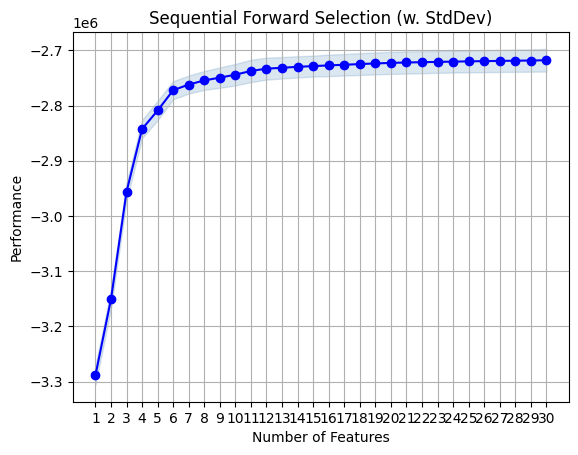

<Figure size 640x480 with 0 Axes>

In [23]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS_DI}/sfs.png") 

In [28]:
sfs_df['feature_names'][10]

('num__latitude',
 'poly__total_area^2',
 'poly__total_area ceiling_height',
 'poly__kitchen_area build_year',
 'poly__kitchen_area floors_total',
 'poly__floors_total rooms',
 'kbin__build_year',
 'cos(num__latitude)',
 'cos(num__longitude)',
 'exp(-num__longitude)')

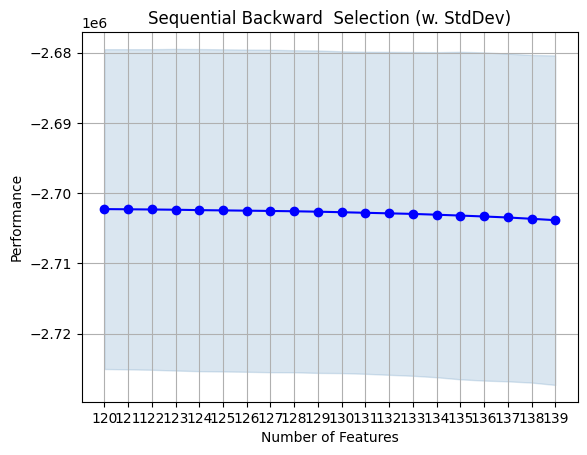

<Figure size 640x480 with 0 Axes>

In [25]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward  Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS_DI}/sbs.png") 

В целом видно что добалвять более чем 30 фич в модель не имеет особого смысла поскольку уже к 30 признакам лосс перестает значимо снижатьсяd_year'

In [33]:
# Сохраним список фич
import pickle

# Сохраняем в файл
with open(f'{FS_ASSETS_DI}/top_feats.pkl', 'wb') as file:
    pickle.dump(top_sfs, file)

In [29]:
# 4.4 Обучение новой версии модели

In [28]:
from sklearn.preprocessing import FunctionTransformer

# Функция для преобразования массива в DataFrame с правильными именами признаков
def to_dataframe(X):
    return pd.DataFrame(X, columns=preprocessor.get_feature_names_out())

# Функция для выбора нужных признаков
def select_features(X):
    selected_features = [f for f in preprocessor.get_feature_names_out() if f in top_sfs]
    return X[selected_features]

In [31]:
# Здесь мы добавим отбор фичей в  модель используя список top_sfs
preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary', sparse_output=False), bin_cols),
        ('cat', CatBoostEncoder(return_df=False), cat_cols),
        ('num', StandardScaler(), num_features + geo_feats),
        ('poly', PolynomialFeatures(degree=2, include_bias=False), num_features),
        ('kbin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), num_features)
    ],
    remainder='drop',
    verbose_feature_names_out=True
)

model = CatBoostRegressor(loss_function='RMSE')

preprocessor.fit(X_train, y_train)


pipeline = Pipeline(
[
    ('preprocessor', preprocessor), 
    ('to_dataframe', FunctionTransformer(to_dataframe)),  
    ('feature_selection', FunctionTransformer(select_features)),
    ('model', model)
]
)

cv_res = cross_validate(
    pipeline,
    X_train[features],
    y_train,
    cv=4,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    )

for key, value in cv_res.items():
    cv_res[key] = round(value.mean(), 3)  



/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to di

Learning rate set to 0.078683
0:	learn: 4387842.7826504	total: 88ms	remaining: 1m 27s
1:	learn: 4210371.6927917	total: 114ms	remaining: 56.9s
2:	learn: 4049290.1688730	total: 142ms	remaining: 47.1s
3:	learn: 3909234.4531781	total: 165ms	remaining: 41.2s
4:	learn: 3784053.8211800	total: 191ms	remaining: 38s
5:	learn: 3673148.2495147	total: 214ms	remaining: 35.5s
6:	learn: 3576230.2847012	total: 237ms	remaining: 33.6s
7:	learn: 3488099.6843356	total: 262ms	remaining: 32.5s
8:	learn: 3408852.8307851	total: 288ms	remaining: 31.7s
9:	learn: 3335843.9448811	total: 309ms	remaining: 30.6s
10:	learn: 3275206.8954134	total: 333ms	remaining: 29.9s
11:	learn: 3220750.6198783	total: 357ms	remaining: 29.4s
12:	learn: 3167439.8780040	total: 379ms	remaining: 28.8s
13:	learn: 3122036.1868342	total: 402ms	remaining: 28.3s
14:	learn: 3081410.4935851	total: 425ms	remaining: 27.9s
15:	learn: 3046982.4644980	total: 449ms	remaining: 27.6s
16:	learn: 3010703.9795974	total: 474ms	remaining: 27.4s
17:	learn: 29

/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


993:	learn: 2279241.7240426	total: 23.1s	remaining: 140ms
994:	learn: 2279054.5793729	total: 23.2s	remaining: 116ms
995:	learn: 2278882.7609750	total: 23.2s	remaining: 93.1ms
996:	learn: 2278705.6782794	total: 23.2s	remaining: 69.9ms
997:	learn: 2278585.1119347	total: 23.2s	remaining: 46.6ms
998:	learn: 2278356.4894921	total: 23.3s	remaining: 23.3ms
999:	learn: 2278191.0067581	total: 23.3s	remaining: 0us
Learning rate set to 0.078683
0:	learn: 4380106.0993988	total: 30.9ms	remaining: 30.9s
1:	learn: 4204278.0577776	total: 57.5ms	remaining: 28.7s
2:	learn: 4045203.3384837	total: 84.9ms	remaining: 28.2s
3:	learn: 3907283.5928466	total: 108ms	remaining: 27s
4:	learn: 3784706.7812923	total: 136ms	remaining: 27s
5:	learn: 3676291.5292584	total: 160ms	remaining: 26.5s
6:	learn: 3579946.7707202	total: 177ms	remaining: 25.1s
7:	learn: 3494057.0345778	total: 203ms	remaining: 25.1s
8:	learn: 3413303.3210310	total: 228ms	remaining: 25.2s
9:	learn: 3345968.3695657	total: 253ms	remaining: 25.1s
10:

In [32]:
cv_res

{'fit_time': 24.183,
 'score_time': 0.12,
 'test_neg_root_mean_squared_error': -2452268.526,
 'test_r2': 0.713,
 'test_neg_mean_absolute_percentage_error': -20.203}

987:	learn: 2295605.2146608	total: 23.2s	remaining: 282ms
988:	learn: 2295485.7235408	total: 23.2s	remaining: 258ms
989:	learn: 2295314.7010166	total: 23.2s	remaining: 235ms
990:	learn: 2295119.4737244	total: 23.3s	remaining: 211ms
991:	learn: 2294888.1684707	total: 23.3s	remaining: 188ms
992:	learn: 2294648.7865486	total: 23.3s	remaining: 164ms
993:	learn: 2294364.5579911	total: 23.3s	remaining: 141ms
994:	learn: 2294169.0397929	total: 23.3s	remaining: 117ms
995:	learn: 2293944.4343011	total: 23.4s	remaining: 93.9ms
996:	learn: 2293752.8516873	total: 23.4s	remaining: 70.4ms
997:	learn: 2293664.9699968	total: 23.4s	remaining: 46.9ms
998:	learn: 2293399.0556876	total: 23.4s	remaining: 23.5ms
999:	learn: 2293295.6113460	total: 23.5s	remaining: 0us
987:	learn: 2286518.6335691	total: 24s	remaining: 291ms
988:	learn: 2286339.8582417	total: 24s	remaining: 267ms
989:	learn: 2286182.6000366	total: 24s	remaining: 242ms
990:	learn: 2285974.9527783	total: 24s	remaining: 218ms
991:	learn: 2285761.

После сокращения количекства признаков до 30 качество даже слегка улучшилось на 0.3 процентных пункта

In [34]:
pipeline.fit(X_train[features], y_train)

/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


Learning rate set to 0.082342
0:	learn: 4382259.5632669	total: 62ms	remaining: 1m 1s
1:	learn: 4197901.3600328	total: 75.5ms	remaining: 37.7s
2:	learn: 4035941.7866752	total: 89.5ms	remaining: 29.7s
3:	learn: 3891536.0548090	total: 103ms	remaining: 25.6s
4:	learn: 3762115.4422092	total: 116ms	remaining: 23.1s
5:	learn: 3648890.9078274	total: 130ms	remaining: 21.5s
6:	learn: 3544794.3443298	total: 143ms	remaining: 20.3s
7:	learn: 3457084.7049408	total: 156ms	remaining: 19.3s
8:	learn: 3372081.2499498	total: 169ms	remaining: 18.6s
9:	learn: 3306096.7164758	total: 182ms	remaining: 18s
10:	learn: 3245127.4010190	total: 197ms	remaining: 17.7s
11:	learn: 3190999.2508607	total: 209ms	remaining: 17.2s
12:	learn: 3139333.4035329	total: 222ms	remaining: 16.9s
13:	learn: 3097365.9587101	total: 235ms	remaining: 16.5s
14:	learn: 3059641.6945434	total: 246ms	remaining: 16.2s
15:	learn: 3024438.7621239	total: 258ms	remaining: 15.9s
16:	learn: 2993177.0671843	total: 271ms	remaining: 15.7s
17:	learn: 2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['is_apartment',
                                                   'has_elevator']),
                                                 ('cat',
                                                  CatBoostEncoder(return_df=False),
                                                  ['building_type_int']),
                                                 ('num', StandardScaler(),
                                                  ['total_area', 'living_area',
                                                   'kitchen_area', 'build_year',
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_he...
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_height',
                                                   'ratio_living_area',
                                                   'ratio_kitchen_area',
                                                   'mean_flats_area'])])),
                ('to_dataframe',
                 FunctionTransformer(func=<function to_dataframe at 0x7fd98763c700>)),
                ('feature_selection',
                 FunctionTransformer(func=<function select_features at 0x7fd96d8920e0>)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fd9757304f0>)])

In [ ]:
# 4.5 Логирование всех артефактов в MLflow

In [35]:
EXPERIMENT_NAME = "sprint2_appartment_price"
RUN_NAME = "save_model_engineered_cut_feats"
REGISTRY_MODEL_NAME = "model_price_appartment"

input_example =  X_train[features][:10]
prediction = pipeline.predict(input_example[:10])
signature = mlflow.models.infer_signature(input_example, prediction)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(cv_res)

    mlflow.log_artifacts(FS_ASSETS_DI) 
    
    model_info = mlflow.sklearn.log_model(
        pipeline, 
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60
		)

/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
2025-04-03 17:24:09,737 INFO: Found credentials in environment variables.
Registered model 'model_price_appartment' already exists. Creating a

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [13]:
from optuna.integration.mlflow import MLflowCallback
import optuna
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from collections import defaultdict

In [9]:
# Сохраним список фич
import pickle


# Загружаем из файла список топ фич на случай если падал сервак либо заканчивалась сессия
with open(f'{FS_ASSETS_DI}/top_feats.pkl', 'rb') as file:
    top_sfs = pickle.load(file)


In [37]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1 с использованием Bayesian Optimization

In [19]:
def objective(trial: optuna.Trial) -> float:
    param = {
    "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
    "depth": trial.suggest_int("depth", 1, 12),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 5),
    "random_strength": trial.suggest_float("random_strength", 0.1, 5),
    "loss_function": "RMSE",
    "task_type": "CPU",
    "random_seed": 0,
    "iterations": trial.suggest_int("iterations", 300, 1000),
    "verbose": False,
    }
    model = CatBoostRegressor(**param)

    skf = StratifiedKFold(n_splits=2)

    metrics = defaultdict(list)
    for i, (train_index, val_index) in enumerate(skf.split(X_train_tr[top_sfs], y_train)):
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train.iloc[val_index] 
        val_y = y_train.iloc[val_index] 

        model.fit(train_x, train_y, eval_set=(val_x, val_y), early_stopping_rounds=50, verbose=False)
        predictions = model.predict(val_x)

        rmse = mean_squared_error(val_y, predictions) ** (0.5)
        r2 = r2_score(val_y, predictions)
        mape = mean_absolute_percentage_error(val_y, predictions)
        

        metrics["rmse"].append(rmse)
        metrics["r2"].append(r2)
        metrics["mape"].append(mape)


    # ваш код здесь #
    rmse = np.median(np.array(metrics['rmse']))
    r2 = np.median(np.array(metrics['r2']))
    mape = np.median(np.array(metrics['mape']))
    return mape

In [20]:
STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "price_appartment_model"

study = optuna.create_study(direction="minimize", study_name=STUDY_NAME, storage=STUDY_DB_NAME, load_if_exists=True, sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)
best_params_bayes = study.best_params


[I 2025-04-03 18:18:48,042] Using an existing study with name 'price_appartment_model' instead of creating a new one.
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
[I 2025-04-03 18:19:14,606] Trial 20 finished with value: 19.790815270409286 and parameters: {'learning_rate': 0.025047152256363475, 'depth': 8, 'l2_leaf_reg': 1.470128734446531, 'random_strength': 0.9412615317972913, 'iterations': 910}. Best is trial 14 with value: 14.81906012464905.
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
[I 2025-04-03 18:20:41,493] Trial 21 finished with value: 16.165213602992374 and parameters: {'learning_rate': 0.080083602797896

In [21]:
best_params_bayes

{'learning_rate': 0.06125243095979619,
 'depth': 12,
 'l2_leaf_reg': 0.9056836318834479,
 'random_strength': 1.2210487322804207,
 'iterations': 659}

In [11]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2 с использованием Random Search

In [22]:

# Случайный сэмплер (Random Search)
sampler = optuna.samplers.RandomSampler(seed=42)

# Гиперпараметры — сетка поиска
def objective(trial: optuna.Trial) -> float:
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),  # разумный диапазон
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 3),
        "random_strength": trial.suggest_float("random_strength", 0.1, 3),
        "loss_function": "RMSE",
        "task_type": "CPU",
        "random_seed": 0,
        "iterations": trial.suggest_int("iterations", 300, 800),
        "verbose": False,
    }

    model = CatBoostRegressor(**param)
    skf = StratifiedKFold(n_splits=2)

    metrics = defaultdict(list)
    for train_index, val_index in skf.split(X_train_tr[top_sfs], y_train):
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train.iloc[val_index] 
        val_y = y_train.iloc[val_index] 

        model.fit(train_x, train_y, eval_set=(val_x, val_y), early_stopping_rounds=50, verbose=False)
        predictions = model.predict(val_x)

        metrics["rmse"].append(mean_squared_error(val_y, predictions) ** 0.5)
        metrics["r2"].append(r2_score(val_y, predictions))
        metrics["mape"].append(mean_absolute_percentage_error(val_y, predictions))

    return np.median(metrics["mape"])  # Целевая метрика

# Создание и запуск исследования с Random Search
STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "price_appartment_model_random_search"

study = optuna.create_study(
    direction="minimize",
    study_name=STUDY_NAME,
    storage=STUDY_DB_NAME,
    load_if_exists=True,
    sampler=sampler,
)

study.optimize(objective, n_trials=20)
best_params_random = study.best_params

[I 2025-04-03 18:49:55,694] Using an existing study with name 'price_appartment_model_random_search' instead of creating a new one.
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
[I 2025-04-03 18:50:27,441] Trial 16 finished with value: 22.19352213089923 and parameters: {'learning_rate': 0.005611516415334507, 'depth': 10, 'l2_leaf_reg': 2.2227824312530746, 'random_strength': 1.8361096041714062, 'iterations': 378}. Best is trial 10 with value: 16.914108311755193.
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
[I 2025-04-03 18:50:36,197] Trial 17 finished with value: 23.54912764253083 and parameters: {'learning_rate': 0.

In [23]:
best_params_random

{'learning_rate': 0.08692991511139551,
 'depth': 9,
 'l2_leaf_reg': 2.8245469305361484,
 'random_strength': 2.6949993162401817,
 'iterations': 599}

In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

In [25]:
final_params = {'learning_rate': 0.06125243095979619,
                 'depth': 12,
                 'l2_leaf_reg': 0.9056836318834479,
                 'random_strength': 1.2210487322804207,
                 'iterations': 659,
                  'loss_function':'RMSE'}

In [26]:
markdown_content = """# Ключевые выводы подбора гиперпараметров
Подбор гиперпараметров смог сильно улучшить итоговое качество

Наилучший метод это Bayesian Optimization

сравнивал его я методом Random Search

Параметры и метрики итоговые такие 
'learning_rate': 0.06125243095979619,
'depth': 12,
'l2_leaf_reg': 0.9056836318834479,
'random_strength': 1.2210487322804207,
'iterations': 659

MAPE:14.55
"""
markdown_file = f"{HYP_ASSETS_DIR}/summary.md"
with open(markdown_file, "w") as f:
    f.write(markdown_content)

import json
with open(f'{HYP_ASSETS_DIR}/final_params.json', 'w', encoding='utf-8') as f:
    json.dump(final_params, f, ensure_ascii=False, indent=4)

In [ ]:
# 5.4 Обуение финальной версии модели

In [29]:
preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary', sparse_output=False), bin_cols),
        ('cat', CatBoostEncoder(return_df=False), cat_cols),
        ('num', StandardScaler(), num_features + geo_feats),
        ('poly', PolynomialFeatures(degree=2, include_bias=False), num_features),
        ('kbin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), num_features)
    ],
    remainder='drop',
    verbose_feature_names_out=True
)

model = CatBoostRegressor(**final_params)

preprocessor.fit(X_train, y_train)


pipeline = Pipeline(
[
    ('preprocessor', preprocessor), 
    ('to_dataframe', FunctionTransformer(to_dataframe)),  
    ('feature_selection', FunctionTransformer(select_features)),
    ('model', model)
]
)

cv_res = cross_validate(
    pipeline,
    X_train[features],
    y_train,
    cv=4,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    )

for key, value in cv_res.items():
    cv_res[key] = round(value.mean(), 3)  



/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to di

0:	learn: 4410109.6997223	total: 265ms	remaining: 2m 54s
1:	learn: 4254667.6468783	total: 462ms	remaining: 2m 31s
2:	learn: 4111751.5715881	total: 661ms	remaining: 2m 24s
3:	learn: 3978760.9804311	total: 875ms	remaining: 2m 23s
4:	learn: 3857356.7527141	total: 1.08s	remaining: 2m 21s
5:	learn: 3746755.3951460	total: 1.28s	remaining: 2m 19s
6:	learn: 3646928.0375551	total: 1.49s	remaining: 2m 18s
7:	learn: 3553314.9585006	total: 1.7s	remaining: 2m 17s
8:	learn: 3467018.1953310	total: 1.89s	remaining: 2m 16s
9:	learn: 3390505.4043514	total: 2.1s	remaining: 2m 16s
10:	learn: 3316833.0461232	total: 2.32s	remaining: 2m 16s
11:	learn: 3248675.0077614	total: 2.53s	remaining: 2m 16s
12:	learn: 3189205.2912735	total: 2.74s	remaining: 2m 16s
13:	learn: 3132787.3260131	total: 2.94s	remaining: 2m 15s
14:	learn: 3084485.0546235	total: 3.14s	remaining: 2m 14s
15:	learn: 3040031.0402249	total: 3.34s	remaining: 2m 14s
16:	learn: 2996024.2957933	total: 3.55s	remaining: 2m 14s
17:	learn: 2954894.3032168

/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


559:	learn: 1915203.6641107	total: 1m 52s	remaining: 19.9s
560:	learn: 1914433.2127993	total: 1m 52s	remaining: 19.7s
561:	learn: 1913614.1013780	total: 1m 52s	remaining: 19.5s
562:	learn: 1912636.6373301	total: 1m 53s	remaining: 19.3s
563:	learn: 1911983.2595293	total: 1m 53s	remaining: 19.1s
564:	learn: 1911491.2487446	total: 1m 53s	remaining: 18.9s
565:	learn: 1910829.4969243	total: 1m 53s	remaining: 18.7s
566:	learn: 1910124.1357371	total: 1m 54s	remaining: 18.5s
567:	learn: 1909474.4887418	total: 1m 54s	remaining: 18.3s
568:	learn: 1908644.5892743	total: 1m 54s	remaining: 18.1s
569:	learn: 1907811.0494990	total: 1m 54s	remaining: 17.9s
570:	learn: 1907246.3379956	total: 1m 54s	remaining: 17.7s
571:	learn: 1906482.7885396	total: 1m 55s	remaining: 17.5s
572:	learn: 1906062.9518004	total: 1m 55s	remaining: 17.3s
573:	learn: 1905340.3803607	total: 1m 55s	remaining: 17.1s
574:	learn: 1904517.2205165	total: 1m 55s	remaining: 16.9s
575:	learn: 1903903.0738782	total: 1m 55s	remaining: 16.

In [30]:
cv_res

{'fit_time': 134.335,
 'score_time': 0.191,
 'test_neg_root_mean_squared_error': -2430797.293,
 'test_r2': 0.718,
 'test_neg_mean_absolute_percentage_error': -16.328}

In [31]:
pipeline.fit(X_train[features], y_train)

/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


0:	learn: 4413890.2796590	total: 112ms	remaining: 1m 13s
1:	learn: 4258213.4083833	total: 217ms	remaining: 1m 11s
2:	learn: 4113934.8425663	total: 321ms	remaining: 1m 10s
3:	learn: 3983658.0201230	total: 425ms	remaining: 1m 9s
4:	learn: 3862100.2314066	total: 532ms	remaining: 1m 9s
5:	learn: 3751005.2275290	total: 636ms	remaining: 1m 9s
6:	learn: 3651350.2676737	total: 741ms	remaining: 1m 9s
7:	learn: 3555008.2449971	total: 845ms	remaining: 1m 8s
8:	learn: 3467808.7606566	total: 950ms	remaining: 1m 8s
9:	learn: 3389005.6702964	total: 1.05s	remaining: 1m 8s
10:	learn: 3315579.1603426	total: 1.16s	remaining: 1m 8s
11:	learn: 3249748.7015961	total: 1.27s	remaining: 1m 8s
12:	learn: 3186955.9584306	total: 1.37s	remaining: 1m 8s
13:	learn: 3131890.8974468	total: 1.48s	remaining: 1m 8s
14:	learn: 3083137.8690702	total: 1.58s	remaining: 1m 8s
15:	learn: 3038516.8969390	total: 1.69s	remaining: 1m 7s
16:	learn: 2997042.6507082	total: 1.79s	remaining: 1m 7s
17:	learn: 2957771.6623801	total: 1.9s

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['is_apartment',
                                                   'has_elevator']),
                                                 ('cat',
                                                  CatBoostEncoder(return_df=False),
                                                  ['building_type_int']),
                                                 ('num', StandardScaler(),
                                                  ['total_area', 'living_area',
                                                   'kitchen_area', 'build_year',
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_he...
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_height',
                                                   'ratio_living_area',
                                                   'ratio_kitchen_area',
                                                   'mean_flats_area'])])),
                ('to_dataframe',
                 FunctionTransformer(func=<function to_dataframe at 0x7fb5f2999a20>)),
                ('feature_selection',
                 FunctionTransformer(func=<function select_features at 0x7fb5f2998af0>)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fb5eb9d6380>)])

599:	learn: 1893180.7197959	total: 2m 1s	remaining: 12s
600:	learn: 1892393.2336703	total: 2m 2s	remaining: 11.8s
601:	learn: 1891568.6232287	total: 2m 2s	remaining: 11.6s
602:	learn: 1890793.6568782	total: 2m 2s	remaining: 11.4s
603:	learn: 1890072.1575424	total: 2m 2s	remaining: 11.2s
604:	learn: 1889509.1302707	total: 2m 2s	remaining: 11s
605:	learn: 1888620.3162365	total: 2m 3s	remaining: 10.8s
606:	learn: 1888210.5703568	total: 2m 3s	remaining: 10.6s
607:	learn: 1887667.1661191	total: 2m 3s	remaining: 10.4s
608:	learn: 1887059.0352336	total: 2m 3s	remaining: 10.2s
609:	learn: 1886545.3116329	total: 2m 3s	remaining: 9.95s
610:	learn: 1885766.3182468	total: 2m 4s	remaining: 9.75s
611:	learn: 1885009.8503587	total: 2m 4s	remaining: 9.55s
612:	learn: 1884213.8394744	total: 2m 4s	remaining: 9.34s
613:	learn: 1883644.1381482	total: 2m 4s	remaining: 9.14s
614:	learn: 1882658.8737589	total: 2m 4s	remaining: 8.94s
615:	learn: 1881896.8577923	total: 2m 5s	remaining: 8.73s
616:	learn: 188111

In [32]:
# 5.5 Логирование артефактов в MLflow

In [33]:
EXPERIMENT_NAME = "sprint2_appartment_price"
RUN_NAME = "save_model_cut_feats_hyperopt"
REGISTRY_MODEL_NAME = "model_price_appartment"

input_example =  X_train[features][:10]
prediction = pipeline.predict(input_example[:10])
signature = mlflow.models.infer_signature(input_example, prediction)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(cv_res)

    mlflow.log_artifacts(HYP_ASSETS_DIR) 
    
    model_info = mlflow.sklearn.log_model(
        pipeline, 
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60
		)

/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
2025-04-03 20:03:07,728 INFO: Found credentials in environment variables.
Registered model 'model_price_appartment' already exists. Creating a